# How to inject artifical signals into K2 light curves

### Example I: supernovae

`lightkurve` will include classes to inject artificial signals (e.g. supernovae, planetary transits, rotation, flares) into K2, Kepler, TESS, and potentially ground based light curves. 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [3]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   # A galaxy observed in K2
lc = tpf.to_lightcurve(aperture_mask='all')           # Returns a KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()              

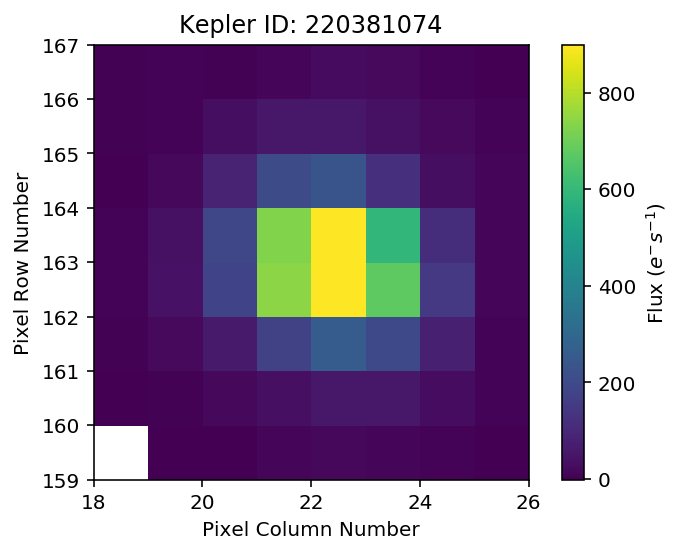

In [4]:
tpf.plot();

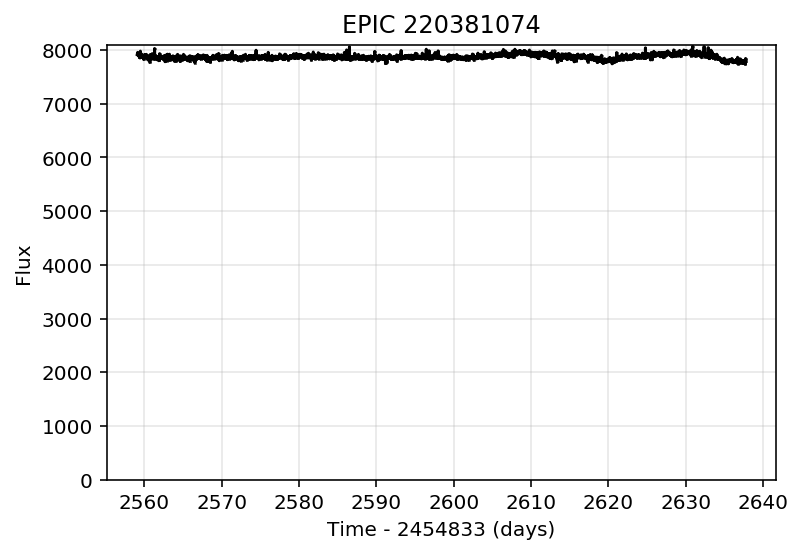

In [7]:
lc.plot(normalize=False);
plt.title('EPIC 220381074')
plt.ylim(0);

The light curve of this galaxy is fairly smooth, with some variability from the spacecraft motion and thermal fluctuations.  Now let's create a supernova model with the new `SupernovaModel` class. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this class to work.

You can specify the source, bandpass, and redshift of the supernova model. These attributes are common to every source.

In [8]:
import lightkurve.injection as inj

Supernova models possess a range of parameters, but generally include some start time $t_0$ (either peak or initial outburst), redshift $z$, and some form of amplitude.  Other parameters may include a measure of emission from radioactive isotopes, reddening, and other refinements.  The `hsiao` model below contains an amplitude parameter $\alpha$ in units of $\rm \frac{photons}{s \; cm^2}$, integrated over the Kepler bandpass.  lightkurve automatically translates these physical source units into Kepler's detector $\rm \frac{e}{s}$:

$$ f (\mathrm{\frac{e}{s}}) = \alpha(\mathrm{\frac{photons}{s \; cm^2}}) \times \frac{A(\mathrm{cm^2})}{1} \times QE \big(\frac{\mathrm{e}}{\mathrm{photon}}\big)$$

where  
$A$ is the light collecting area of Kepler and,  
$QE$ is the (wavelength dependent) quantum effiency of *Kepler* CCDs.

The spectral response that SNcosmos uses *already includes* the QE as a function of wavelength, so the SNcosmo is actually delivering $\rm \frac{e}{s \; cm^2}$.  The effective light collecting area of the telescope also includes obscuration and vignetting, which are summarized in Section 3.6 of the Kepler instrument handbook.  Ignoring vignetting we have:

$$A_{eff} \sim (1 - 0.227) \times \pi (\frac{0.95 \mathrm{m}}{2})^2$$
$$A_{eff} \sim 5480 \; \mathrm{cm^2}$$

In [34]:
A_eff_cm2 = (1 - 0.227) * np.pi * (95/2 )**2 #95 cm telescope

5479.192842263703

So we simply need to multiply the output of `SNcosmo` by the $A_{eff}$ factor, and we will have units of electrons per second.  You can inspect the bandpass used in sncosmo by:  

```python
import pandas as pd
df = pd.read_csv('~/.astropy/cache/sncosmo/bandpasses/kepler/kepler_response_hires1.txt', 
                 skiprows=9, delim_whitespace=True, names=['wl', 'trans'])
plt.plot(df.wl, df.trans)
```

In [42]:
sn_model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=1.e-7)

You can preview the light curve with the `.evaluate` method, which computes the model function at each time point.

# TODO--- put this factor of 5480 into the code.

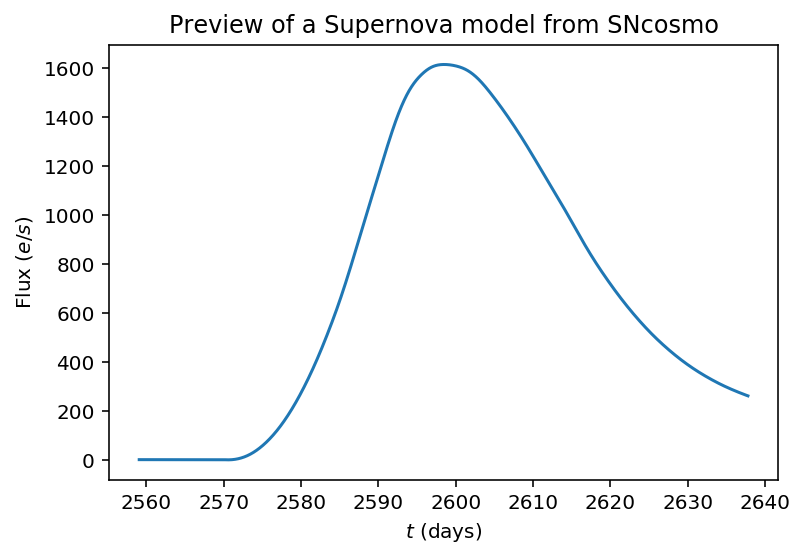

In [43]:
sn_flux = sn_model.evaluate(lc.time)*5480.0
plt.plot(lc.time, sn_flux)
plt.title('Preview of a Supernova model from SNcosmo')
plt.ylabel('Flux $(e/s)$')
plt.xlabel('$t$ (days)');

Finally, we can inject the supernova model into our K2 light curve using the `.inject` method. We don't need to pre-compute the supernova model, simply pass in the model object will get computed at the same time points as the lightcurve object.  Let's plot the K2 light curve and the injected light curve next to it.

[5.51621147e-21 5.51621147e-21 5.51621147e-21 ... 4.76115632e-02
 4.75686002e-02 4.75257137e-02]


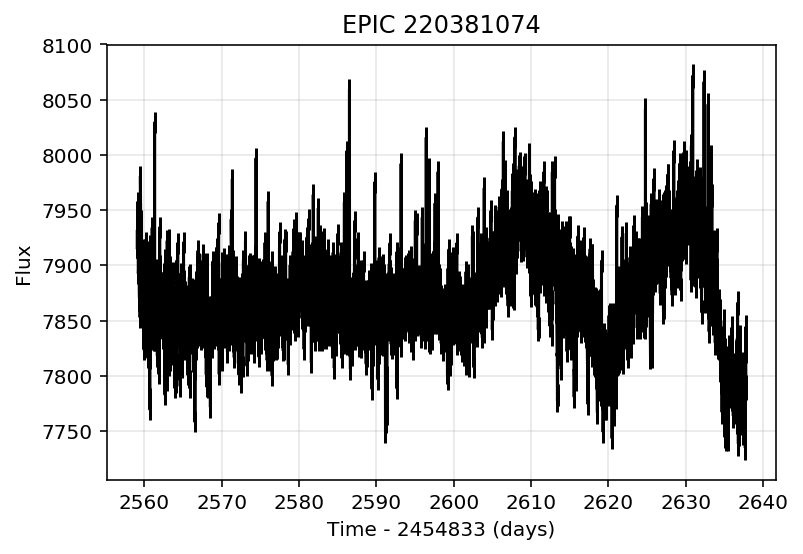

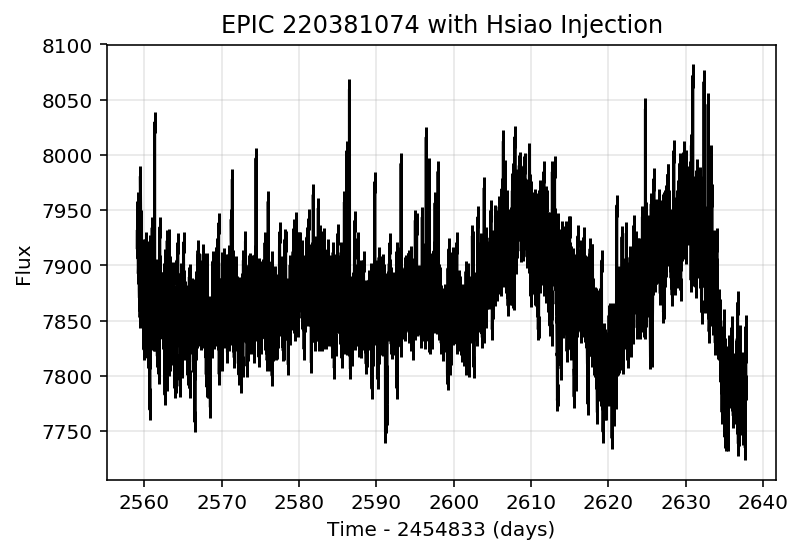

In [45]:
lcinj = inj.inject(lc, sn_model)

#K2 light curve
lc.plot(normalize=False)
plt.title('EPIC 220381074')

#K2 light curve with injection
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 with Hsiao Injection')

print(lcinj.signal)

We injected a supernova light curve into this galaxy!

This supernova is based on the [Hsiao](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) source 
and takes three parameters: redshift $z$, amplitude, and $t_0$ (time of zero phase). 
<br>
(Note: depending on the source, $t_0$ may specify the beginning or the peak of the supernova.)
<br>

You can specify the source and input the parameters belonging to this source accordingly. Paramters can also be chosen randomly from a uniform distribution using `inj.UniformDistribution`, or a Gaussian distribution using `inj.GaussianDistribution`. For example, let's simulate a supernova with the SALT2 model, which takes 5 parameters ($t_0$, $z$, $x_0$, $x_1$, and $c$), and choose $z$ randomly from a Gaussian distribution with mean 0.5 and sigma 0.2:

Text(0.5,1,'EPIC 220381074 with SALT2 Injection')

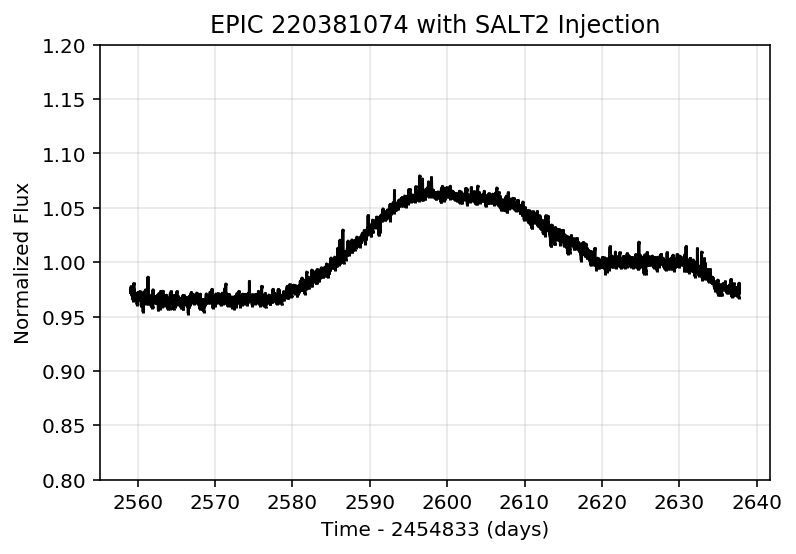

In [8]:
model = inj.SupernovaModel(T0=2600, source='salt2', bandpass='kepler', z=inj.UniformDistribution(0.3,0.5), x0=5, x1=1.e-2, c=-.1)
lcinj = inj.inject(lc, model)
lcinj.plot()
plt.ylim(0.8,1.2)
plt.title('EPIC 220381074 with SALT2 Injection')

Every time you create a new model, a new $z$ will be chosen from this Gaussian distribution, so you can quickly inject supernovae of many $z$ values.

We can also use the .inject method to inject a planetary transit. Let's download the Kepler light curve of a G-type star:

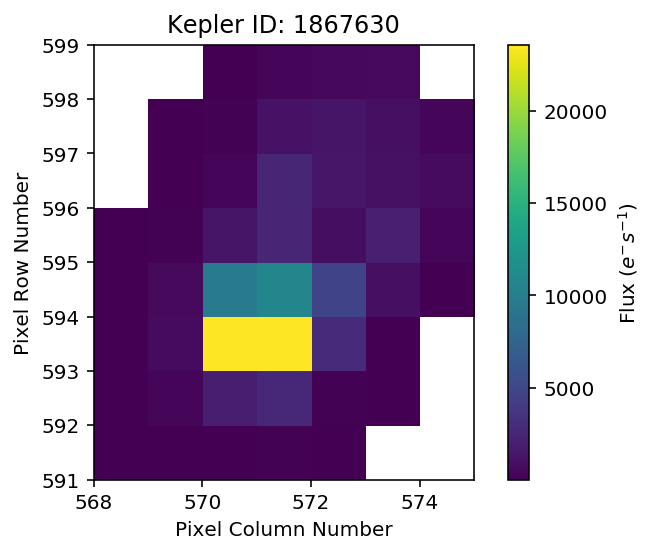

In [9]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

tpf.plot()

(0, 1.2)

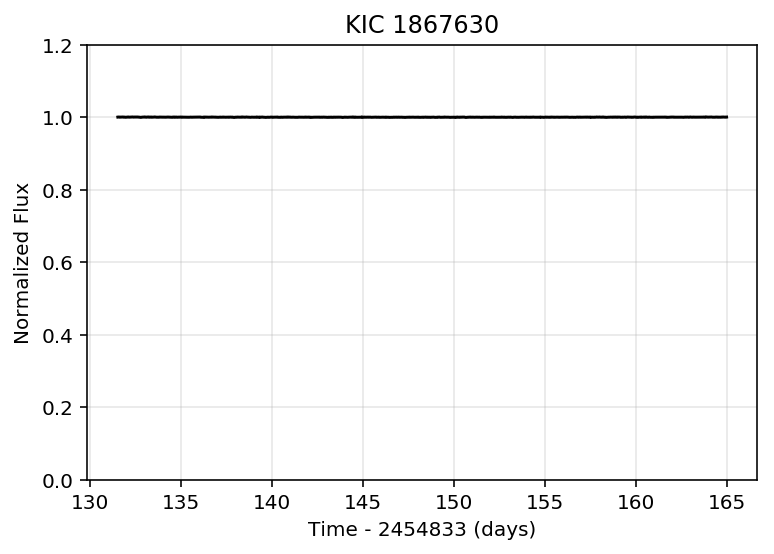

In [10]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0, 1.2)

The Kepler light curve of this star is very smooth, but if we zoom in we can see that there is some slight variability: 

(0.985, 1.004)

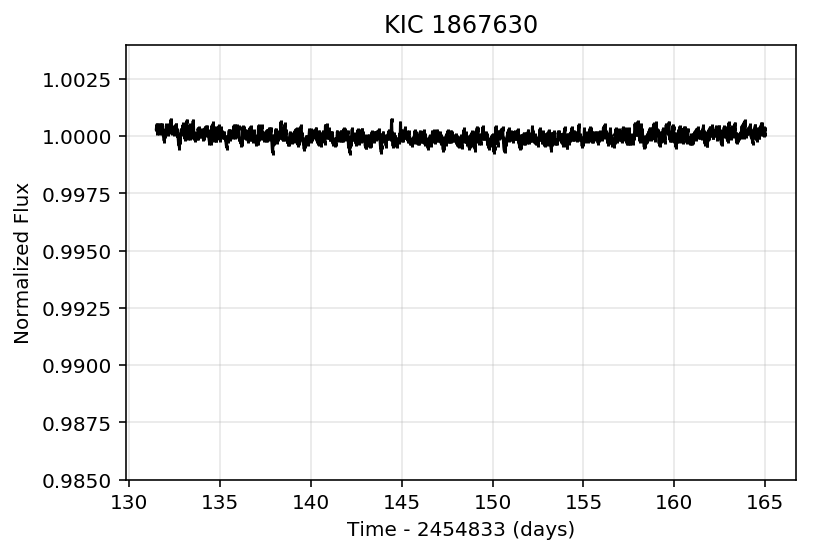

In [11]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0.985, 1.004)
#plt.savefig('/Users/sheilasagear/Desktop/lc_notransits')

Now let's inject a planetary transit into this light curve. We're going to inject a jupiter-sized planet with an orbital period chosen from a uniform distribution between 4 and 8 days using `TransitModel`.

(0.985, 1.004)

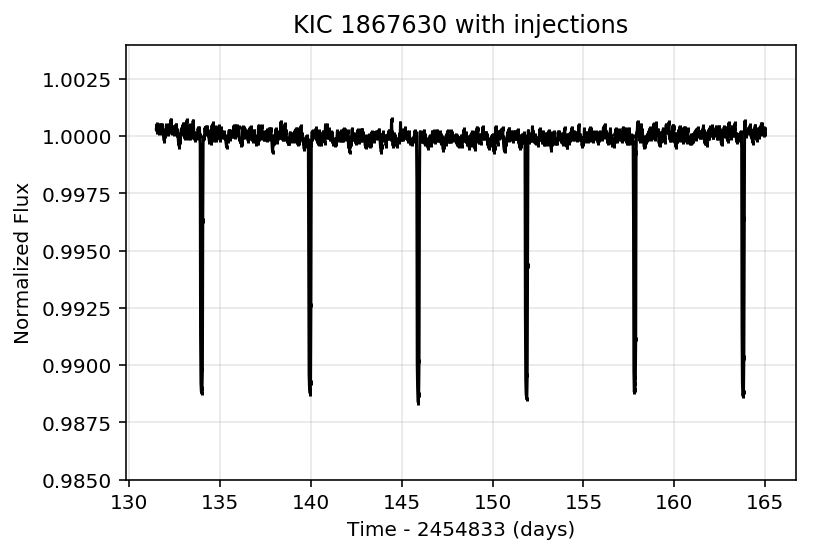

In [13]:
model = inj.TransitModel()
model.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model.add_planet(period=inj.UniformDistribution(4,8), T0=134, rprs=.1)


lc_transit = inj.inject(lc, model)
#print(lc_transit.period)

#print(lc_transit.signal)

lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
#plt.savefig('/Users/sheilasagear/Desktop/lc_1transit')

You can add as many planets as you want:

## Exploratory analysis:

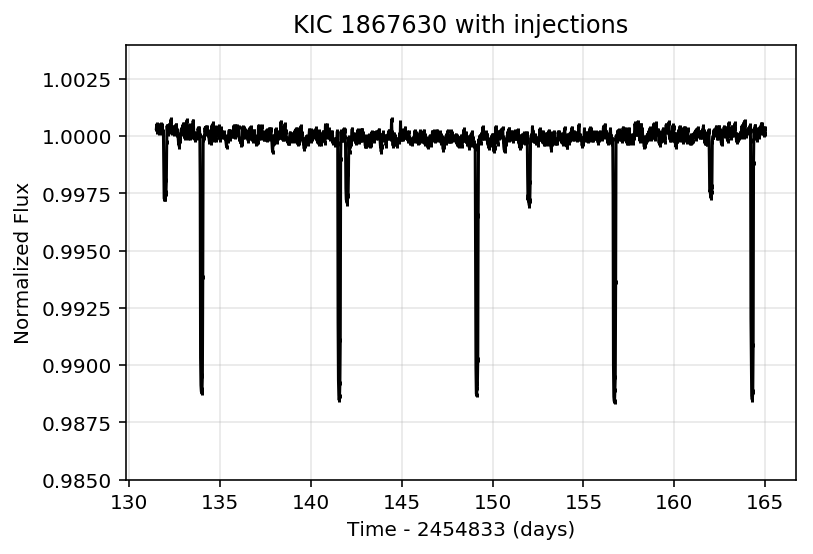

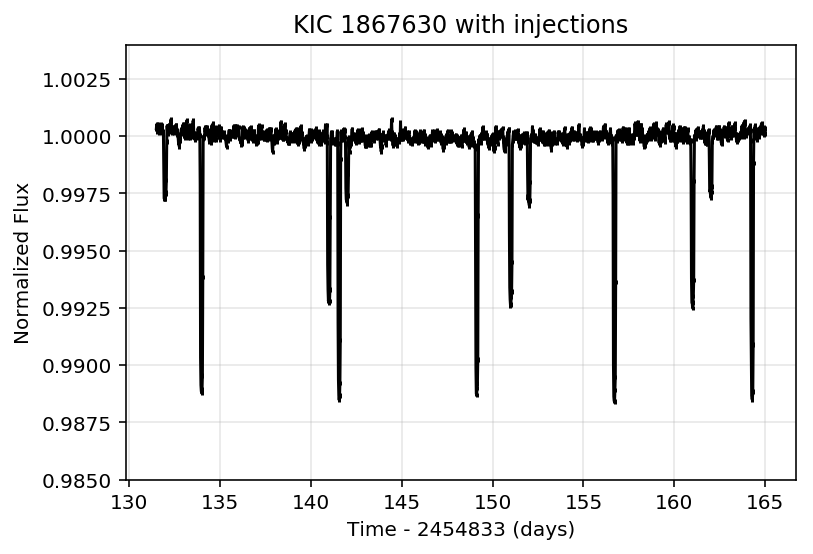

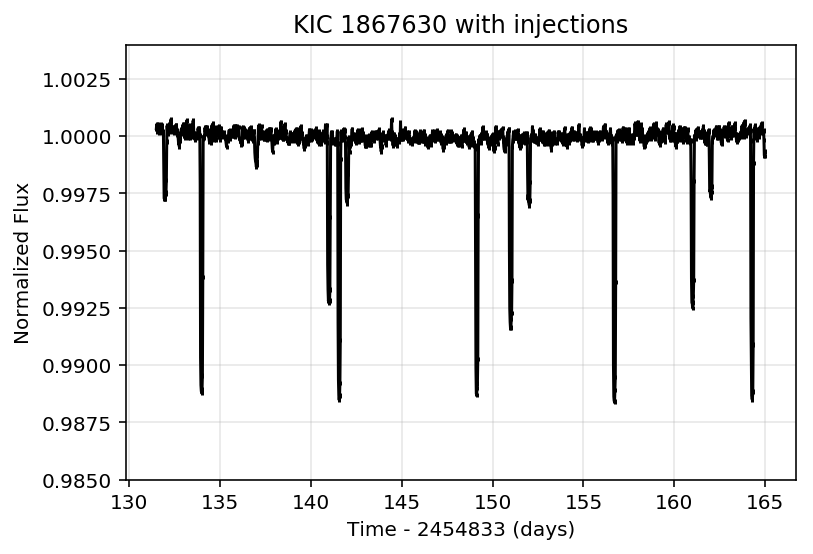

In [12]:
model.add_planet(period=10, rprs=.05, T0=132, impact=0.01)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_2transit')

model.add_planet(period=10, rprs=.08, T0=131, impact=0.0)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_3transit')

model.add_planet(period=14, rprs=.03, T0=137, impact=0.4)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_4transit')

You can specify the orbital period and radius ratio, but also the impact parameter, eccentricity, stellar density, and limb darkening law, etc.

lc.model

lc.signal -- an array

read sff paper and watch gully's tutorial abt sff

for w, b
    lc.inject.correct(w,b)

In [87]:
lc_transit.chisq(model, 3, period=[1, 2, 3], rprs=[0.1,0.2,0.3], impact=[0.0, 0.1, 0.2])

{'impact': [0.0, 0.1, 0.2], 'period': [1, 2, 3], 'rprs': [0.1, 0.2, 0.3]}
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.  1.  0.1 0. ]
 [0.1 2.  0.2 0. ]
 [0.2 3.  0.3 0. ]]


In [70]:
#add signal attribute to TransitModel and SupernovaModel
p  = (1,2,3,4,5)
r  = (1,2,3,4,5)
x  = (1,2,3,4,5)

N_parsa = 3

def count():
    number = len(data)
    
    new_dat = np.zeros(shape=(len(data),N_parsa))
    
    return (new_dat)
    

In [25]:
count(data)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])